In [1]:
import pandas as pd
from sklearn.metrics import *
from tqdm import tqdm
from utils import HeteroDataProcessor,HeteroDataProcessorFilterNode
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP
from torch_geometric.nn import HANConv, Linear


In [2]:

# Usage
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

time_cut =30

processor = HeteroDataProcessorFilterNode(file_path_replies, file_path_posts, time_cut)
data = processor.process()


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


In [8]:
data

HeteroData(
  id={
    x=[51, 106],
    y=[51],
    train_mask=[51],
    val_mask=[51],
    test_mask=[51],
  },
  reply_user_id={ x=[278, 104] },
  (id, retweet, reply_user_id)={ edge_index=[2, 278] },
  (reply_user_id, rev_retweet, id)={ edge_index=[2, 278] }
)

In [6]:
class HAN(nn.Module):
    def __init__(self, dim_in, dim_out, dim_h=64, heads=4):
        super().__init__()
        self.han = HANConv(dim_in, dim_h, heads=heads,dropout=0.2, metadata=data.metadata())
        self.han2 = HANConv(dim_h, dim_h, heads=heads, dropout=0.2, metadata=data.metadata())
        self.linear = nn.Linear(dim_h, dim_out)

    def forward(self, x_dict, edge_index_dict):
        out = self.han(x_dict, edge_index_dict)
        out = self.han2(out, edge_index_dict)
        out = self.linear(out['id'])
        return out
    
@torch.no_grad()
def test(mask):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
    acc = (pred[mask] == data['id'].y[mask]).sum() / mask.sum()
    return float(acc)

In [19]:
model = HAN(dim_in=-1, dim_out=2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['id'].train_mask
    loss = F.cross_entropy(out[mask], data['id'].y[mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        train_acc = test(data['id'].train_mask)
        val_acc = test(data['id'].val_mask)
        print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')

test_acc = test(data['id'].test_mask)
print(f'Test accuracy: {test_acc*100:.2f}%')

Epoch:   0 | Train Loss: 0.6954 | Train Acc: 51.43% | Val Acc: 28.57%
Epoch:  20 | Train Loss: 0.5230 | Train Acc: 91.43% | Val Acc: 100.00%
Epoch:  40 | Train Loss: 0.2179 | Train Acc: 97.14% | Val Acc: 100.00%
Epoch:  60 | Train Loss: 0.0686 | Train Acc: 100.00% | Val Acc: 100.00%
Epoch:  80 | Train Loss: 0.0131 | Train Acc: 100.00% | Val Acc: 100.00%
Epoch: 100 | Train Loss: 0.0059 | Train Acc: 100.00% | Val Acc: 100.00%
Epoch: 120 | Train Loss: 0.0030 | Train Acc: 100.00% | Val Acc: 100.00%


KeyboardInterrupt: 

In [17]:
test_mask = data['id'].test_mask | data['id'].val_mask
pred =model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
true_labels = data['id'].y[test_mask]
pred_labels = pred[test_mask]
precision_score(true_labels, pred_labels, average='macro')

0.8666666666666667

In [18]:
recall_score(true_labels, pred_labels, average='macro')

0.8666666666666667

In [4]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("HAN 2024-09-28 2 layers Filter Node 17min-3days")

2024/09/29 11:07:24 INFO mlflow.tracking.fluent: Experiment with name 'HAN 2024-09-28 2 layers Filter Node 17min-3days' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/azureuser/rumour-detection-pheme/mlruns/30', creation_time=1727608044542, experiment_id='30', last_update_time=1727608044542, lifecycle_stage='active', name='HAN 2024-09-28 2 layers Filter Node 17min-3days', tags={}>

In [11]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

for time_cut in range(17,24*3*60,10):
    print(time_cut)
    processor = HeteroDataProcessorFilterNode(file_path_replies, file_path_posts, time_cut)
    data = processor.process()

    model = HAN(dim_in=-1, dim_out=2)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
   
    with mlflow.start_run():

        for epoch in range(200):
            model.train()
            optimizer.zero_grad()
            out = model(data.x_dict, data.edge_index_dict)
            mask = data['id'].train_mask
            loss = F.cross_entropy(out[mask], data['id'].y[mask])
            loss.backward()
            optimizer.step()

        if epoch % 20 == 0:
            train_acc = test(data['id'].train_mask)
            val_acc = test(data['id'].val_mask)
            print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')

        test_acc = test(data['id'].test_mask)
        train_acc = test(data['id'].train_mask)
        val_acc = test(data['id'].val_mask)
        print(f'Test accuracy: {test_acc*100:.2f}%')



        test_mask = data['id'].test_mask | data['id'].val_mask
        pred =model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
        true_labels = data['id'].y[test_mask]
        pred_labels = pred[test_mask]
        test_precision =precision_score(true_labels, pred_labels, average='macro')
        test_recall=recall_score(true_labels, pred_labels, average='macro')
        print(f'Test Recall: {test_recall*100:.2f}%')
        print(f'Test Precision: {test_precision*100:.2f}%')

        mlflow.log_metric("train_loss", loss.item(), step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)
        mlflow.log_metric("test_acc", test_acc)
        mlflow.log_metric("test_precision",  test_precision)
        mlflow.log_metric("test_recall",  test_recall)

            
        mlflow.log_param("learning_rate", 0.001)
        mlflow.log_param("epochs", 200)
        mlflow.log_metric("time_cut", time_cut)



        
            
        mlflow.pytorch.log_model(model, f"HAN_model_{time_cut}")


17


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 100.00%
Test Recall: 83.33%
Test Precision: 90.00%


2024/09/29 11:11:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


27


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.50%
Test Recall: 85.42%
Test Precision: 85.42%


2024/09/29 11:11:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


37


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.67%
Test Recall: 80.00%
Test Precision: 87.50%


2024/09/29 11:11:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


47


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 71.43%
Test Recall: 78.33%
Test Precision: 78.02%


2024/09/29 11:11:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


57


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 94.12%
Test Recall: 94.44%
Test Precision: 94.12%


2024/09/29 11:11:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


67


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.00%
Test Recall: 74.65%
Test Precision: 78.21%


2024/09/29 11:11:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


77


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.30%
Test Recall: 91.01%
Test Precision: 91.50%


2024/09/29 11:11:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


87


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.19%
Test Recall: 88.39%
Test Precision: 88.39%


2024/09/29 11:12:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


97


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 81.25%
Test Recall: 86.25%
Test Precision: 83.82%


2024/09/29 11:12:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


107


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 80.56%
Test Recall: 85.80%
Test Precision: 87.48%


2024/09/29 11:12:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


117


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 78.05%
Test Recall: 78.07%
Test Precision: 76.87%


2024/09/29 11:12:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


127


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 78.72%
Test Recall: 80.49%
Test Precision: 78.33%


2024/09/29 11:12:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


137


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 94.34%
Test Recall: 92.93%
Test Precision: 88.44%


2024/09/29 11:12:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


147


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.98%
Test Recall: 90.68%
Test Precision: 89.72%


2024/09/29 11:12:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


157


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.89%
Test Recall: 87.88%
Test Precision: 89.08%


2024/09/29 11:13:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


167


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.55%
Test Recall: 84.99%
Test Precision: 86.05%


2024/09/29 11:13:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


177


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.32%
Test Recall: 86.80%
Test Precision: 88.05%


2024/09/29 11:13:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


187


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.84%
Test Recall: 87.24%
Test Precision: 84.43%


2024/09/29 11:13:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


197


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.68%
Test Recall: 86.35%
Test Precision: 88.58%


2024/09/29 11:13:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


207


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.91%
Test Recall: 85.79%
Test Precision: 91.60%


2024/09/29 11:13:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


217


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 96.81%
Test Recall: 91.37%
Test Precision: 89.94%


2024/09/29 11:14:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


227


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.91%
Test Recall: 84.95%
Test Precision: 87.15%


2024/09/29 11:14:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


237


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.26%
Test Recall: 88.09%
Test Precision: 86.63%


2024/09/29 11:14:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


247


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.65%
Test Recall: 85.68%
Test Precision: 90.35%


2024/09/29 11:14:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


257


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.19%
Test Recall: 83.04%
Test Precision: 80.11%


2024/09/29 11:14:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


267


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 93.04%
Test Recall: 79.08%
Test Precision: 85.31%


2024/09/29 11:15:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


277


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 93.22%
Test Recall: 86.61%
Test Precision: 88.38%


2024/09/29 11:15:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


287


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.83%
Test Recall: 88.41%
Test Precision: 90.51%


2024/09/29 11:15:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


297


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 94.87%
Test Recall: 78.46%
Test Precision: 82.63%


2024/09/29 11:15:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


307


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 94.87%
Test Recall: 85.13%
Test Precision: 86.65%


2024/09/29 11:15:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


317


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 94.92%
Test Recall: 87.42%
Test Precision: 87.42%


2024/09/29 11:16:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


327


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.29%
Test Recall: 82.46%
Test Precision: 80.45%


2024/09/29 11:16:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


337


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.98%
Test Recall: 80.36%
Test Precision: 82.46%


2024/09/29 11:16:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


347


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.60%
Test Recall: 87.95%
Test Precision: 89.35%


2024/09/29 11:16:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


357


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.76%
Test Recall: 88.32%
Test Precision: 84.60%


2024/09/29 11:16:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


367


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.44%
Test Recall: 89.51%
Test Precision: 85.13%


2024/09/29 11:17:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


377


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 94.12%
Test Recall: 85.32%
Test Precision: 91.44%


2024/09/29 11:17:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


387


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 94.12%
Test Recall: 81.95%
Test Precision: 83.88%


2024/09/29 11:17:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


397


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.92%
Test Recall: 88.50%
Test Precision: 89.11%


2024/09/29 11:17:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


407


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.71%
Test Recall: 81.58%
Test Precision: 78.23%


2024/09/29 11:17:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


417


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.60%
Test Recall: 86.45%
Test Precision: 86.45%


2024/09/29 11:18:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


427


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.08%
Test Recall: 89.80%
Test Precision: 80.71%


2024/09/29 11:18:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


437


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.44%
Test Recall: 88.44%
Test Precision: 90.55%


2024/09/29 11:18:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


447


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 93.28%
Test Recall: 87.73%
Test Precision: 92.06%


2024/09/29 11:18:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


457


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.92%
Test Recall: 84.65%
Test Precision: 84.65%


2024/09/29 11:18:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


467


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.08%
Test Recall: 84.06%
Test Precision: 83.54%


2024/09/29 11:19:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


477


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.76%
Test Recall: 82.70%
Test Precision: 82.12%


2024/09/29 11:19:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


487


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.39%
Test Recall: 82.74%
Test Precision: 81.64%


2024/09/29 11:19:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


497


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 93.28%
Test Recall: 85.53%
Test Precision: 83.14%


2024/09/29 11:19:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


507


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 94.12%
Test Recall: 84.23%
Test Precision: 90.20%


2024/09/29 11:19:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


517


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.67%
Test Recall: 84.97%
Test Precision: 84.97%


2024/09/29 11:20:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


527


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.00%
Test Recall: 82.53%
Test Precision: 81.85%


2024/09/29 11:20:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


537


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.67%
Test Recall: 85.17%
Test Precision: 86.03%


2024/09/29 11:20:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


547


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.00%
Test Recall: 81.85%
Test Precision: 82.53%


2024/09/29 11:20:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


557


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.67%
Test Recall: 77.75%
Test Precision: 79.62%


2024/09/29 11:20:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


567


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.33%
Test Recall: 82.34%
Test Precision: 85.00%


2024/09/29 11:21:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


577


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.17%
Test Recall: 89.72%
Test Precision: 86.22%


2024/09/29 11:21:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


587


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.67%
Test Recall: 78.83%
Test Precision: 80.84%


2024/09/29 11:21:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


597


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.50%
Test Recall: 89.10%
Test Precision: 81.67%


2024/09/29 11:21:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


607


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 95.00%
Test Recall: 80.94%
Test Precision: 86.88%


2024/09/29 11:21:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


617


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.67%
Test Recall: 84.62%
Test Precision: 85.78%


2024/09/29 11:22:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


627


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.67%
Test Recall: 78.51%
Test Precision: 89.01%


2024/09/29 11:22:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


637


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.67%
Test Recall: 81.94%
Test Precision: 79.84%


2024/09/29 11:22:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


647


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.50%
Test Recall: 80.86%
Test Precision: 82.35%


2024/09/29 11:22:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


657


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.50%
Test Recall: 87.45%
Test Precision: 85.44%


2024/09/29 11:22:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


667


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.17%
Test Recall: 77.21%
Test Precision: 81.53%


2024/09/29 11:23:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


677


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.67%
Test Recall: 81.34%
Test Precision: 82.46%


2024/09/29 11:23:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


687


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.67%
Test Recall: 79.20%
Test Precision: 76.63%


2024/09/29 11:23:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


697


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 95.00%
Test Recall: 83.68%
Test Precision: 82.07%


2024/09/29 11:23:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


707


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.17%
Test Recall: 82.96%
Test Precision: 87.51%


2024/09/29 11:23:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


717


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.00%
Test Recall: 84.53%
Test Precision: 81.74%


2024/09/29 11:24:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


727


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 95.83%
Test Recall: 87.71%
Test Precision: 88.39%


2024/09/29 11:24:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


737


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.17%
Test Recall: 78.40%
Test Precision: 81.05%


2024/09/29 11:24:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


747


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.33%
Test Recall: 82.37%
Test Precision: 86.23%


2024/09/29 11:24:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


757


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 93.33%
Test Recall: 83.86%
Test Precision: 88.10%


2024/09/29 11:24:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


767


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.00%
Test Recall: 81.30%
Test Precision: 79.11%


2024/09/29 11:25:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


777


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.07%
Test Recall: 86.14%
Test Precision: 82.52%


2024/09/29 11:25:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


787


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.06%
Test Recall: 75.34%
Test Precision: 86.57%


2024/09/29 11:25:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


797


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.34%
Test Recall: 84.65%
Test Precision: 83.00%


2024/09/29 11:25:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


807


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.46%
Test Recall: 85.36%
Test Precision: 86.52%


2024/09/29 11:25:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


817


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.23%
Test Recall: 78.70%
Test Precision: 79.22%


2024/09/29 11:26:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


827


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.31%
Test Recall: 84.11%
Test Precision: 86.25%


2024/09/29 11:26:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


837


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.37%
Test Recall: 79.31%
Test Precision: 80.35%


2024/09/29 11:26:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


847


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.00%
Test Recall: 85.09%
Test Precision: 88.07%


2024/09/29 11:26:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


857


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.62%
Test Recall: 72.59%
Test Precision: 74.69%


2024/09/29 11:26:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


867


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.00%
Test Recall: 77.75%
Test Precision: 82.30%


2024/09/29 11:27:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


877


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.38%
Test Recall: 77.89%
Test Precision: 75.22%


2024/09/29 11:27:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


887


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.23%
Test Recall: 76.67%
Test Precision: 84.18%


2024/09/29 11:27:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


897


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.46%
Test Recall: 84.04%
Test Precision: 84.88%


2024/09/29 11:27:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


907


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.23%
Test Recall: 77.26%
Test Precision: 81.26%


2024/09/29 11:27:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


917


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.77%
Test Recall: 85.37%
Test Precision: 87.20%


2024/09/29 11:28:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


927


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.31%
Test Recall: 88.77%
Test Precision: 87.47%


2024/09/29 11:28:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


937


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.00%
Test Recall: 76.75%
Test Precision: 81.70%


2024/09/29 11:28:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


947


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.69%
Test Recall: 83.42%
Test Precision: 86.03%


2024/09/29 11:28:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


957


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.00%
Test Recall: 82.34%
Test Precision: 85.55%


2024/09/29 11:28:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


967


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.77%
Test Recall: 80.61%
Test Precision: 84.25%


2024/09/29 11:29:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


977


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.69%
Test Recall: 77.49%
Test Precision: 84.72%


2024/09/29 11:29:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


987


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.54%
Test Recall: 82.72%
Test Precision: 87.83%


2024/09/29 11:29:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


997


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.23%
Test Recall: 80.97%
Test Precision: 83.69%


2024/09/29 11:29:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1007


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.00%
Test Recall: 76.60%
Test Precision: 85.36%


2024/09/29 11:29:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1017


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.23%
Test Recall: 82.72%
Test Precision: 86.20%


2024/09/29 11:30:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1027


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.85%
Test Recall: 82.36%
Test Precision: 75.34%


2024/09/29 11:30:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1037


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.23%
Test Recall: 83.83%
Test Precision: 83.18%


2024/09/29 11:30:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1047


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.23%
Test Recall: 82.15%
Test Precision: 86.05%


2024/09/29 11:30:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1057


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.00%
Test Recall: 79.10%
Test Precision: 84.20%


2024/09/29 11:31:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1067


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.00%
Test Recall: 80.68%
Test Precision: 90.27%


2024/09/29 11:31:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1077


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.00%
Test Recall: 84.51%
Test Precision: 81.58%


2024/09/29 11:31:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1087


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.85%
Test Recall: 81.68%
Test Precision: 79.82%


2024/09/29 11:31:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1097


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.77%
Test Recall: 79.19%
Test Precision: 77.15%


2024/09/29 11:31:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1107


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.92%
Test Recall: 79.99%
Test Precision: 79.14%


2024/09/29 11:32:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1117


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.23%
Test Recall: 81.58%
Test Precision: 85.33%


2024/09/29 11:32:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1127


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.77%
Test Recall: 82.43%
Test Precision: 80.51%


2024/09/29 11:32:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1137


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.77%
Test Recall: 83.81%
Test Precision: 84.43%


2024/09/29 11:32:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1147


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.08%
Test Recall: 84.69%
Test Precision: 80.77%


2024/09/29 11:32:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1157


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.54%
Test Recall: 85.35%
Test Precision: 81.20%


2024/09/29 11:33:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1167


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 93.85%
Test Recall: 88.95%
Test Precision: 84.85%


2024/09/29 11:33:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1177


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.46%
Test Recall: 81.85%
Test Precision: 84.73%


2024/09/29 11:33:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1187


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.23%
Test Recall: 81.09%
Test Precision: 85.81%


2024/09/29 11:33:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1197


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.46%
Test Recall: 86.03%
Test Precision: 81.94%


2024/09/29 11:33:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1207


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 93.08%
Test Recall: 81.33%
Test Precision: 86.91%


2024/09/29 11:34:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1217


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.46%
Test Recall: 83.97%
Test Precision: 79.32%


2024/09/29 11:34:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1227


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.00%
Test Recall: 77.13%
Test Precision: 81.11%


2024/09/29 11:34:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1237


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.92%
Test Recall: 79.32%
Test Precision: 76.89%


2024/09/29 11:34:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1247


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.84%
Test Recall: 76.39%
Test Precision: 85.97%


2024/09/29 11:34:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1257


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.85%
Test Recall: 76.53%
Test Precision: 79.02%


2024/09/29 11:35:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1267


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.98%
Test Recall: 80.66%
Test Precision: 84.80%


2024/09/29 11:35:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1277


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.67%
Test Recall: 79.11%
Test Precision: 77.41%


2024/09/29 11:35:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1287


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.71%
Test Recall: 82.64%
Test Precision: 89.04%


2024/09/29 11:35:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1297


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.70%
Test Recall: 86.93%
Test Precision: 83.98%


2024/09/29 11:35:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1307


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.61%
Test Recall: 74.89%
Test Precision: 81.53%


2024/09/29 11:36:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1317


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.86%
Test Recall: 84.10%
Test Precision: 87.36%


2024/09/29 11:36:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1327


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 93.62%
Test Recall: 89.24%
Test Precision: 88.18%


2024/09/29 11:36:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1337


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.61%
Test Recall: 82.45%
Test Precision: 82.45%


2024/09/29 11:36:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1347


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.50%
Test Recall: 81.90%
Test Precision: 82.87%


2024/09/29 11:36:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1357


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.83%
Test Recall: 76.75%
Test Precision: 82.88%


2024/09/29 11:37:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1367


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 93.15%
Test Recall: 84.40%
Test Precision: 86.25%


2024/09/29 11:37:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1377


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.49%
Test Recall: 78.66%
Test Precision: 79.45%


2024/09/29 11:37:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1387


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.26%
Test Recall: 82.17%
Test Precision: 83.54%


2024/09/29 11:37:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1397


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.00%
Test Recall: 82.12%
Test Precision: 78.50%


2024/09/29 11:38:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1407


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.79%
Test Recall: 80.80%
Test Precision: 79.17%


2024/09/29 11:38:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1417


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.31%
Test Recall: 82.14%
Test Precision: 80.01%


2024/09/29 11:38:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1427


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.39%
Test Recall: 83.38%
Test Precision: 84.81%


2024/09/29 11:38:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1437


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.18%
Test Recall: 80.97%
Test Precision: 84.36%


2024/09/29 11:38:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1447


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.38%
Test Recall: 77.92%
Test Precision: 85.39%


2024/09/29 11:39:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1457


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.68%
Test Recall: 82.31%
Test Precision: 79.50%


2024/09/29 11:39:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1467


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 93.25%
Test Recall: 92.07%
Test Precision: 85.64%


2024/09/29 11:39:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1477


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.63%
Test Recall: 82.11%
Test Precision: 85.97%


2024/09/29 11:39:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1487


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.36%
Test Recall: 83.98%
Test Precision: 82.34%


2024/09/29 11:40:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1497


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.62%
Test Recall: 87.64%
Test Precision: 87.64%


2024/09/29 11:40:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1507


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.69%
Test Recall: 77.65%
Test Precision: 83.40%


2024/09/29 11:40:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1517


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.64%
Test Recall: 84.13%
Test Precision: 86.47%


2024/09/29 11:40:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1527


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.72%
Test Recall: 82.98%
Test Precision: 84.76%


2024/09/29 11:40:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1537


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.02%
Test Recall: 84.04%
Test Precision: 84.49%


2024/09/29 11:41:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1547


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.57%
Test Recall: 80.60%
Test Precision: 79.38%


2024/09/29 11:41:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1557


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.40%
Test Recall: 89.53%
Test Precision: 85.55%


2024/09/29 11:41:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1567


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.57%
Test Recall: 82.29%
Test Precision: 84.53%


2024/09/29 11:41:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1577


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.06%
Test Recall: 85.62%
Test Precision: 82.94%


2024/09/29 11:42:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1587


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.11%
Test Recall: 82.09%
Test Precision: 78.63%


2024/09/29 11:42:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1597


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.11%
Test Recall: 81.48%
Test Precision: 84.44%


2024/09/29 11:42:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1607


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.35%
Test Recall: 83.74%
Test Precision: 84.48%


2024/09/29 11:42:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1617


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.40%
Test Recall: 82.48%
Test Precision: 83.64%


2024/09/29 11:43:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1627


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.98%
Test Recall: 80.35%
Test Precision: 85.27%


2024/09/29 11:43:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1637


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.23%
Test Recall: 80.09%
Test Precision: 79.32%


2024/09/29 11:43:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1647


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.11%
Test Recall: 80.16%
Test Precision: 83.19%


2024/09/29 11:43:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1657


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.34%
Test Recall: 69.93%
Test Precision: 77.61%


2024/09/29 11:44:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1667


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.56%
Test Recall: 74.56%
Test Precision: 77.72%


2024/09/29 11:44:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1677


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 94.33%
Test Recall: 85.59%
Test Precision: 87.61%


2024/09/29 11:44:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1687


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.77%
Test Recall: 77.47%
Test Precision: 76.66%


2024/09/29 11:44:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1697


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.36%
Test Recall: 77.60%
Test Precision: 75.87%


2024/09/29 11:45:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1707


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.41%
Test Recall: 83.68%
Test Precision: 86.62%


2024/09/29 11:45:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1717


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.50%
Test Recall: 81.98%
Test Precision: 88.32%


2024/09/29 11:45:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1727


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.61%
Test Recall: 78.79%
Test Precision: 77.86%


2024/09/29 11:45:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1737


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 93.10%
Test Recall: 81.41%
Test Precision: 81.41%


2024/09/29 11:46:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1747


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.67%
Test Recall: 77.15%
Test Precision: 83.10%


2024/09/29 11:46:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1757


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.41%
Test Recall: 77.72%
Test Precision: 76.67%


2024/09/29 11:46:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1767


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.90%
Test Recall: 76.83%
Test Precision: 84.33%


2024/09/29 11:46:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1777


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 93.81%
Test Recall: 80.47%
Test Precision: 85.01%


2024/09/29 11:47:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1787


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.00%
Test Recall: 76.45%
Test Precision: 83.01%


2024/09/29 11:47:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1797


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.47%
Test Recall: 80.47%
Test Precision: 86.24%


2024/09/29 11:47:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1807


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.10%
Test Recall: 80.58%
Test Precision: 81.30%


2024/09/29 11:47:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1817


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.00%
Test Recall: 79.29%
Test Precision: 83.77%


2024/09/29 11:48:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1827


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.15%
Test Recall: 80.96%
Test Precision: 84.56%


2024/09/29 11:48:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1837


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.47%
Test Recall: 80.56%
Test Precision: 81.85%


2024/09/29 11:48:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1847


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.57%
Test Recall: 81.23%
Test Precision: 79.86%


2024/09/29 11:48:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1857


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.00%
Test Recall: 83.23%
Test Precision: 84.88%


2024/09/29 11:49:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1867


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.63%
Test Recall: 76.01%
Test Precision: 84.53%


2024/09/29 11:49:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1877


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.89%
Test Recall: 85.34%
Test Precision: 82.86%


2024/09/29 11:49:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1887


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.10%
Test Recall: 82.00%
Test Precision: 87.35%


2024/09/29 11:49:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1897


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.10%
Test Recall: 83.72%
Test Precision: 81.60%


2024/09/29 11:50:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1907


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.68%
Test Recall: 77.63%
Test Precision: 80.23%


2024/09/29 11:50:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1917


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.04%
Test Recall: 77.09%
Test Precision: 83.37%


2024/09/29 11:50:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1927


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.92%
Test Recall: 82.20%
Test Precision: 79.46%


2024/09/29 11:50:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1937


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.98%
Test Recall: 82.22%
Test Precision: 81.42%


2024/09/29 11:51:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1947


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.68%
Test Recall: 79.59%
Test Precision: 79.28%


2024/09/29 11:51:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1957


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.57%
Test Recall: 77.64%
Test Precision: 75.83%


2024/09/29 11:51:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1967


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.04%
Test Recall: 82.02%
Test Precision: 83.00%


2024/09/29 11:52:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1977


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.21%
Test Recall: 81.30%
Test Precision: 78.73%


2024/09/29 11:52:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1987


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.62%
Test Recall: 83.71%
Test Precision: 83.71%


2024/09/29 11:52:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1997


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 93.87%
Test Recall: 86.32%
Test Precision: 83.90%


2024/09/29 11:52:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2007


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.68%
Test Recall: 79.93%
Test Precision: 82.43%


2024/09/29 11:53:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2017


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.04%
Test Recall: 80.27%
Test Precision: 79.88%


2024/09/29 11:53:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2027


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.51%
Test Recall: 84.45%
Test Precision: 85.77%


2024/09/29 11:53:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2037


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.57%
Test Recall: 82.72%
Test Precision: 82.72%


2024/09/29 11:53:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2047


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.51%
Test Recall: 81.23%
Test Precision: 81.66%


2024/09/29 11:54:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2057


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.57%
Test Recall: 81.24%
Test Precision: 83.13%


2024/09/29 11:54:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2067


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.62%
Test Recall: 78.11%
Test Precision: 79.59%


2024/09/29 11:54:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2077


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.79%
Test Recall: 78.33%
Test Precision: 74.26%


2024/09/29 11:54:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2087


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.45%
Test Recall: 85.45%
Test Precision: 83.71%


2024/09/29 11:55:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2097


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.51%
Test Recall: 82.73%
Test Precision: 80.78%


2024/09/29 11:55:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2107


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.45%
Test Recall: 80.06%
Test Precision: 86.42%


2024/09/29 11:55:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2117


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 93.87%
Test Recall: 85.70%
Test Precision: 80.87%


2024/09/29 11:55:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2127


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.98%
Test Recall: 76.25%
Test Precision: 79.35%


2024/09/29 11:56:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2137


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.26%
Test Recall: 76.45%
Test Precision: 81.22%


2024/09/29 11:56:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2147


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.51%
Test Recall: 81.52%
Test Precision: 80.69%


2024/09/29 11:56:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2157


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.45%
Test Recall: 78.73%
Test Precision: 81.18%


2024/09/29 11:56:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2167


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.15%
Test Recall: 75.45%
Test Precision: 80.70%


2024/09/29 11:57:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2177


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.09%
Test Recall: 86.18%
Test Precision: 81.70%


2024/09/29 11:57:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2187


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.62%
Test Recall: 78.19%
Test Precision: 83.78%


2024/09/29 11:57:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2197


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.45%
Test Recall: 82.29%
Test Precision: 82.85%


2024/09/29 11:57:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2207


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.68%
Test Recall: 76.74%
Test Precision: 78.02%


2024/09/29 11:58:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2217


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.09%
Test Recall: 83.33%
Test Precision: 81.11%


2024/09/29 11:58:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2227


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.57%
Test Recall: 76.02%
Test Precision: 83.63%


2024/09/29 11:58:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2237


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.51%
Test Recall: 80.33%
Test Precision: 78.31%


2024/09/29 11:58:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2247


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.98%
Test Recall: 75.17%
Test Precision: 86.10%


2024/09/29 11:59:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2257


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.09%
Test Recall: 78.86%
Test Precision: 79.21%


2024/09/29 11:59:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2267


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.68%
Test Recall: 79.19%
Test Precision: 77.78%


2024/09/29 11:59:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2277


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.68%
Test Recall: 82.02%
Test Precision: 79.34%


2024/09/29 11:59:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2287


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.45%
Test Recall: 74.71%
Test Precision: 76.68%


2024/09/29 12:00:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2297


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.09%
Test Recall: 80.41%
Test Precision: 81.95%


2024/09/29 12:00:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2307


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.09%
Test Recall: 77.57%
Test Precision: 79.29%


2024/09/29 12:00:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2317


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.68%
Test Recall: 78.02%
Test Precision: 80.94%


2024/09/29 12:01:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2327


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 94.81%
Test Recall: 86.19%
Test Precision: 83.35%


2024/09/29 12:01:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2337


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.04%
Test Recall: 79.19%
Test Precision: 85.85%


2024/09/29 12:01:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2347


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.62%
Test Recall: 78.05%
Test Precision: 78.41%


2024/09/29 12:01:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2357


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.74%
Test Recall: 77.92%
Test Precision: 79.72%


2024/09/29 12:02:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2367


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.62%
Test Recall: 74.83%
Test Precision: 80.98%


2024/09/29 12:02:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2377


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.15%
Test Recall: 78.06%
Test Precision: 82.17%


2024/09/29 12:02:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2387


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.45%
Test Recall: 81.88%
Test Precision: 81.43%


2024/09/29 12:02:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2397


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.21%
Test Recall: 77.09%
Test Precision: 76.30%


2024/09/29 12:03:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2407


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.98%
Test Recall: 83.89%
Test Precision: 78.29%


2024/09/29 12:03:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2417


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.45%
Test Recall: 79.62%
Test Precision: 81.82%


2024/09/29 12:03:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2427


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.32%
Test Recall: 77.85%
Test Precision: 77.55%


2024/09/29 12:03:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2437


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.15%
Test Recall: 79.12%
Test Precision: 80.49%


2024/09/29 12:04:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2447


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.79%
Test Recall: 75.25%
Test Precision: 76.98%


2024/09/29 12:04:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2457


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.09%
Test Recall: 77.46%
Test Precision: 81.66%


2024/09/29 12:04:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2467


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.62%
Test Recall: 77.56%
Test Precision: 82.80%


2024/09/29 12:04:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2477


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.74%
Test Recall: 78.99%
Test Precision: 79.32%


2024/09/29 12:05:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2487


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.15%
Test Recall: 78.26%
Test Precision: 81.06%


2024/09/29 12:05:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2497


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 93.87%
Test Recall: 78.60%
Test Precision: 86.32%


2024/09/29 12:05:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2507


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 94.34%
Test Recall: 84.13%
Test Precision: 86.51%


2024/09/29 12:05:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2517


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.04%
Test Recall: 79.14%
Test Precision: 83.38%


2024/09/29 12:06:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2527


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.51%
Test Recall: 76.62%
Test Precision: 80.65%


2024/09/29 12:06:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2537


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.09%
Test Recall: 78.49%
Test Precision: 83.06%


2024/09/29 12:06:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2547


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.15%
Test Recall: 85.40%
Test Precision: 81.26%


2024/09/29 12:06:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2557


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.98%
Test Recall: 77.73%
Test Precision: 81.86%


2024/09/29 12:07:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2567


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.15%
Test Recall: 79.31%
Test Precision: 77.60%


2024/09/29 12:07:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2577


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.57%
Test Recall: 80.32%
Test Precision: 81.66%


2024/09/29 12:07:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2587


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.62%
Test Recall: 81.88%
Test Precision: 78.88%


2024/09/29 12:07:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2597


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.74%
Test Recall: 81.27%
Test Precision: 80.64%


2024/09/29 12:08:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2607


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.26%
Test Recall: 80.05%
Test Precision: 82.07%


2024/09/29 12:08:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2617


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.51%
Test Recall: 78.67%
Test Precision: 82.97%


2024/09/29 12:08:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2627


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.74%
Test Recall: 79.37%
Test Precision: 80.14%


2024/09/29 12:09:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2637


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.09%
Test Recall: 81.12%
Test Precision: 82.00%


2024/09/29 12:09:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2647


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 94.34%
Test Recall: 81.12%
Test Precision: 84.71%


2024/09/29 12:09:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2657


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.21%
Test Recall: 77.89%
Test Precision: 81.28%


2024/09/29 12:09:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2667


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.15%
Test Recall: 82.98%
Test Precision: 81.53%


2024/09/29 12:10:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2677


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.04%
Test Recall: 77.32%
Test Precision: 81.01%


2024/09/29 12:10:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2687


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.26%
Test Recall: 76.88%
Test Precision: 78.91%


2024/09/29 12:10:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2697


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.57%
Test Recall: 80.24%
Test Precision: 81.98%


2024/09/29 12:10:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2707


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.67%
Test Recall: 77.09%
Test Precision: 76.77%


2024/09/29 12:11:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2717


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.67%
Test Recall: 79.11%
Test Precision: 81.70%


2024/09/29 12:11:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2727


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.52%
Test Recall: 81.82%
Test Precision: 81.82%


2024/09/29 12:11:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2737


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.98%
Test Recall: 73.83%
Test Precision: 76.86%


2024/09/29 12:11:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2747


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.78%
Test Recall: 84.17%
Test Precision: 84.17%


2024/09/29 12:12:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2757


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.69%
Test Recall: 78.46%
Test Precision: 86.43%


2024/09/29 12:12:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2767


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.91%
Test Recall: 77.35%
Test Precision: 77.90%


2024/09/29 12:12:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2777


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.64%
Test Recall: 76.83%
Test Precision: 77.53%


2024/09/29 12:12:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2787


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.34%
Test Recall: 74.73%
Test Precision: 73.32%


2024/09/29 12:13:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2797


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.16%
Test Recall: 77.03%
Test Precision: 80.86%


2024/09/29 12:13:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2807


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.05%
Test Recall: 80.33%
Test Precision: 83.64%


2024/09/29 12:13:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2817


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.31%
Test Recall: 83.47%
Test Precision: 84.71%


2024/09/29 12:13:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2827


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 92.98%
Test Recall: 84.17%
Test Precision: 86.18%


2024/09/29 12:14:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2837


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.96%
Test Recall: 81.62%
Test Precision: 85.20%


2024/09/29 12:14:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2847


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.21%
Test Recall: 78.57%
Test Precision: 85.19%


2024/09/29 12:14:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2857


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.87%
Test Recall: 84.96%
Test Precision: 84.10%


2024/09/29 12:15:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2867


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.61%
Test Recall: 83.71%
Test Precision: 85.06%


2024/09/29 12:15:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2877


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.36%
Test Recall: 79.24%
Test Precision: 80.14%


2024/09/29 12:15:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2887


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.99%
Test Recall: 82.70%
Test Precision: 82.70%


2024/09/29 12:15:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2897


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.47%
Test Recall: 80.80%
Test Precision: 79.66%


2024/09/29 12:16:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2907


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.03%
Test Recall: 85.62%
Test Precision: 85.62%


2024/09/29 12:16:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2917


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.94%
Test Recall: 83.63%
Test Precision: 83.92%


2024/09/29 12:16:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2927


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.14%
Test Recall: 83.26%
Test Precision: 85.56%


2024/09/29 12:16:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2937


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.56%
Test Recall: 84.81%
Test Precision: 83.92%


2024/09/29 12:17:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2947


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.24%
Test Recall: 79.45%
Test Precision: 83.16%


2024/09/29 12:17:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2957


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.92%
Test Recall: 85.95%
Test Precision: 83.41%


2024/09/29 12:17:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2967


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.00%
Test Recall: 84.37%
Test Precision: 84.64%


2024/09/29 12:18:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2977


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.32%
Test Recall: 83.74%
Test Precision: 83.44%


2024/09/29 12:18:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2987


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.34%
Test Recall: 79.00%
Test Precision: 84.60%


2024/09/29 12:18:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2997


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.47%
Test Recall: 85.63%
Test Precision: 84.48%


2024/09/29 12:18:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3007


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.15%
Test Recall: 83.72%
Test Precision: 84.43%


2024/09/29 12:19:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3017


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.76%
Test Recall: 85.02%
Test Precision: 81.89%


2024/09/29 12:19:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3027


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.33%
Test Recall: 83.71%
Test Precision: 85.59%


2024/09/29 12:19:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3037


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.64%
Test Recall: 80.88%
Test Precision: 83.31%


2024/09/29 12:20:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3047


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.23%
Test Recall: 85.84%
Test Precision: 80.82%


2024/09/29 12:20:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3057


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.79%
Test Recall: 82.50%
Test Precision: 82.72%


2024/09/29 12:20:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3067


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.77%
Test Recall: 83.81%
Test Precision: 83.81%


2024/09/29 12:20:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3077


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.76%
Test Recall: 87.06%
Test Precision: 82.27%


2024/09/29 12:21:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3087


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.67%
Test Recall: 84.71%
Test Precision: 84.93%


2024/09/29 12:21:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3097


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.78%
Test Recall: 82.74%
Test Precision: 82.34%


2024/09/29 12:21:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3107


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.24%
Test Recall: 79.87%
Test Precision: 79.87%


2024/09/29 12:22:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3117


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.60%
Test Recall: 83.01%
Test Precision: 81.51%


2024/09/29 12:22:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3127


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.86%
Test Recall: 82.01%
Test Precision: 78.94%


2024/09/29 12:22:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3137


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.91%
Test Recall: 78.33%
Test Precision: 78.73%


2024/09/29 12:23:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3147


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.09%
Test Recall: 80.23%
Test Precision: 82.78%


2024/09/29 12:23:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3157


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.33%
Test Recall: 82.45%
Test Precision: 84.55%


2024/09/29 12:23:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3167


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.74%
Test Recall: 81.34%
Test Precision: 84.86%


2024/09/29 12:23:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3177


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.52%
Test Recall: 82.18%
Test Precision: 84.04%


2024/09/29 12:24:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3187


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.51%
Test Recall: 80.55%
Test Precision: 80.93%


2024/09/29 12:24:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3197


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.51%
Test Recall: 78.15%
Test Precision: 80.18%


2024/09/29 12:24:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3207


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.35%
Test Recall: 78.19%
Test Precision: 79.15%


2024/09/29 12:25:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3217


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.04%
Test Recall: 81.82%
Test Precision: 81.82%


2024/09/29 12:25:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3227


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.39%
Test Recall: 72.96%
Test Precision: 76.32%


2024/09/29 12:25:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3237


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.37%
Test Recall: 84.18%
Test Precision: 82.71%


2024/09/29 12:26:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3247


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 81.06%
Test Recall: 79.52%
Test Precision: 78.04%


2024/09/29 12:26:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3257


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.37%
Test Recall: 78.88%
Test Precision: 83.46%


2024/09/29 12:26:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3267


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.05%
Test Recall: 79.65%
Test Precision: 82.08%


2024/09/29 12:27:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3277


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.04%
Test Recall: 81.46%
Test Precision: 82.23%


2024/09/29 12:27:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3287


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.37%
Test Recall: 84.58%
Test Precision: 83.36%


2024/09/29 12:27:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3297


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.05%
Test Recall: 82.00%
Test Precision: 81.32%


2024/09/29 12:28:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3307


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.04%
Test Recall: 79.45%
Test Precision: 80.35%


2024/09/29 12:28:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3317


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.72%
Test Recall: 78.56%
Test Precision: 81.81%


2024/09/29 12:28:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3327


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.71%
Test Recall: 81.98%
Test Precision: 80.05%


2024/09/29 12:29:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3337


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.03%
Test Recall: 81.47%
Test Precision: 83.48%


2024/09/29 12:29:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3347


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.71%
Test Recall: 79.37%
Test Precision: 77.22%


2024/09/29 12:29:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3357


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.38%
Test Recall: 80.33%
Test Precision: 77.74%


2024/09/29 12:30:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3367


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.38%
Test Recall: 81.03%
Test Precision: 80.86%


2024/09/29 12:30:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3377


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.38%
Test Recall: 80.70%
Test Precision: 83.67%


2024/09/29 12:30:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3387


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.05%
Test Recall: 81.56%
Test Precision: 77.73%


2024/09/29 12:31:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3397


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.38%
Test Recall: 75.06%
Test Precision: 80.25%


2024/09/29 12:31:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3407


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 82.06%
Test Recall: 79.52%
Test Precision: 78.70%


2024/09/29 12:31:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3417


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.38%
Test Recall: 79.90%
Test Precision: 80.65%


2024/09/29 12:31:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3427


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.72%
Test Recall: 76.66%
Test Precision: 78.74%


2024/09/29 12:32:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3437


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.37%
Test Recall: 82.73%
Test Precision: 78.24%


2024/09/29 12:32:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3447


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.71%
Test Recall: 82.03%
Test Precision: 83.50%


2024/09/29 12:32:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3457


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.05%
Test Recall: 73.67%
Test Precision: 76.42%


2024/09/29 12:33:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3467


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.72%
Test Recall: 78.90%
Test Precision: 83.05%


2024/09/29 12:33:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3477


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.05%
Test Recall: 81.88%
Test Precision: 79.93%


2024/09/29 12:33:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3487


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.72%
Test Recall: 81.72%
Test Precision: 78.45%


2024/09/29 12:34:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3497


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.04%
Test Recall: 79.15%
Test Precision: 80.95%


2024/09/29 12:34:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3507


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.71%
Test Recall: 80.16%
Test Precision: 79.83%


2024/09/29 12:34:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3517


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.05%
Test Recall: 80.92%
Test Precision: 80.11%


2024/09/29 12:35:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3527


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.71%
Test Recall: 77.62%
Test Precision: 78.22%


2024/09/29 12:35:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3537


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.72%
Test Recall: 77.28%
Test Precision: 78.90%


2024/09/29 12:35:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3547


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.04%
Test Recall: 76.79%
Test Precision: 80.11%


2024/09/29 12:36:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3557


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.38%
Test Recall: 80.92%
Test Precision: 82.26%


2024/09/29 12:36:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3567


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.38%
Test Recall: 82.15%
Test Precision: 82.47%


2024/09/29 12:36:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3577


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.70%
Test Recall: 79.63%
Test Precision: 82.43%


2024/09/29 12:37:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3587


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.04%
Test Recall: 83.18%
Test Precision: 81.75%


2024/09/29 12:37:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3597


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.04%
Test Recall: 80.31%
Test Precision: 81.45%


2024/09/29 12:37:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3607


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.71%
Test Recall: 82.69%
Test Precision: 80.57%


2024/09/29 12:38:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3617


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.05%
Test Recall: 84.28%
Test Precision: 81.26%


2024/09/29 12:38:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3627


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.06%
Test Recall: 78.39%
Test Precision: 75.20%


2024/09/29 12:38:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3637


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.38%
Test Recall: 80.47%
Test Precision: 80.95%


2024/09/29 12:39:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3647


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.71%
Test Recall: 78.71%
Test Precision: 81.67%


2024/09/29 12:39:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3657


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.70%
Test Recall: 84.44%
Test Precision: 83.76%


2024/09/29 12:39:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3667


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.37%
Test Recall: 84.23%
Test Precision: 84.58%


2024/09/29 12:40:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3677


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.70%
Test Recall: 81.44%
Test Precision: 83.96%


2024/09/29 12:40:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3687


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.71%
Test Recall: 80.43%
Test Precision: 81.59%


2024/09/29 12:40:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3697


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.71%
Test Recall: 82.59%
Test Precision: 79.99%


2024/09/29 12:41:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3707


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.38%
Test Recall: 80.21%
Test Precision: 80.35%


2024/09/29 12:41:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3717


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.38%
Test Recall: 84.33%
Test Precision: 79.67%


2024/09/29 12:41:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3727


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.37%
Test Recall: 76.18%
Test Precision: 79.22%


2024/09/29 12:42:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3737


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.04%
Test Recall: 76.99%
Test Precision: 80.97%


2024/09/29 12:42:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3747


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.05%
Test Recall: 80.14%
Test Precision: 82.47%


2024/09/29 12:42:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3757


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.72%
Test Recall: 80.57%
Test Precision: 78.94%


2024/09/29 12:43:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3767


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.71%
Test Recall: 78.20%
Test Precision: 80.74%


2024/09/29 12:43:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3777


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.72%
Test Recall: 82.39%
Test Precision: 78.04%


2024/09/29 12:43:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3787


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.04%
Test Recall: 78.62%
Test Precision: 80.26%


2024/09/29 12:44:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3797


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.04%
Test Recall: 82.15%
Test Precision: 82.51%


2024/09/29 12:44:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3807


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.05%
Test Recall: 79.27%
Test Precision: 80.47%


2024/09/29 12:44:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3817


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.05%
Test Recall: 77.34%
Test Precision: 80.21%


2024/09/29 12:45:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3827


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 82.06%
Test Recall: 76.88%
Test Precision: 75.69%


2024/09/29 12:45:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3837


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.71%
Test Recall: 78.88%
Test Precision: 82.62%


2024/09/29 12:45:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3847


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.05%
Test Recall: 78.69%
Test Precision: 79.51%


2024/09/29 12:46:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3857


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.38%
Test Recall: 82.32%
Test Precision: 85.67%


2024/09/29 12:46:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3867


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.71%
Test Recall: 77.84%
Test Precision: 77.38%


2024/09/29 12:46:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3877


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.06%
Test Recall: 75.16%
Test Precision: 76.86%


2024/09/29 12:47:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3887


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 82.72%
Test Recall: 78.84%
Test Precision: 76.61%


2024/09/29 12:47:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3897


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.05%
Test Recall: 82.26%
Test Precision: 80.27%


2024/09/29 12:47:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3907


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.71%
Test Recall: 80.61%
Test Precision: 80.45%


2024/09/29 12:47:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3917


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.71%
Test Recall: 81.22%
Test Precision: 81.72%


2024/09/29 12:48:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3927


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.71%
Test Recall: 76.64%
Test Precision: 78.50%


2024/09/29 12:48:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3937


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.72%
Test Recall: 79.49%
Test Precision: 80.06%


2024/09/29 12:48:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3947


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.38%
Test Recall: 82.14%
Test Precision: 81.84%


2024/09/29 12:49:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3957


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.38%
Test Recall: 80.11%
Test Precision: 80.26%


2024/09/29 12:49:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3967


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.39%
Test Recall: 78.79%
Test Precision: 81.67%


2024/09/29 12:49:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3977


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 91.69%
Test Recall: 82.25%
Test Precision: 84.36%


2024/09/29 12:50:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3987


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.38%
Test Recall: 80.52%
Test Precision: 79.45%


2024/09/29 12:50:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3997


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.72%
Test Recall: 77.47%
Test Precision: 78.65%


2024/09/29 12:50:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4007


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 90.03%
Test Recall: 82.86%
Test Precision: 82.71%


2024/09/29 12:51:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4017


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.04%
Test Recall: 79.87%
Test Precision: 82.49%


2024/09/29 12:51:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4027


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.05%
Test Recall: 75.41%
Test Precision: 79.87%


2024/09/29 12:51:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4037


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.05%
Test Recall: 75.49%
Test Precision: 76.92%


2024/09/29 12:52:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4047


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.71%
Test Recall: 80.03%
Test Precision: 83.10%


2024/09/29 12:52:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4057


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.70%
Test Recall: 80.35%
Test Precision: 81.79%


2024/09/29 12:52:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4067


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.71%
Test Recall: 78.88%
Test Precision: 79.61%


2024/09/29 12:53:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4077


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.04%
Test Recall: 82.84%
Test Precision: 84.63%


2024/09/29 12:53:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4087


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.05%
Test Recall: 79.88%
Test Precision: 82.27%


2024/09/29 12:53:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4097


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.38%
Test Recall: 79.36%
Test Precision: 81.03%


2024/09/29 12:54:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4107


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.05%
Test Recall: 83.68%
Test Precision: 79.01%


2024/09/29 12:54:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4117


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.04%
Test Recall: 79.51%
Test Precision: 80.51%


2024/09/29 12:54:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4127


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.05%
Test Recall: 82.65%
Test Precision: 79.59%


2024/09/29 12:55:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4137


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.39%
Test Recall: 79.64%
Test Precision: 80.04%


2024/09/29 12:55:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4147


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.71%
Test Recall: 81.00%
Test Precision: 84.24%


2024/09/29 12:55:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4157


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.71%
Test Recall: 81.02%
Test Precision: 81.39%


2024/09/29 12:56:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4167


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.71%
Test Recall: 80.31%
Test Precision: 82.09%


2024/09/29 12:56:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4177


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.72%
Test Recall: 79.29%
Test Precision: 79.29%


2024/09/29 12:56:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4187


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.04%
Test Recall: 82.24%
Test Precision: 81.71%


2024/09/29 12:57:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4197


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.38%
Test Recall: 80.36%
Test Precision: 84.83%


2024/09/29 12:57:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4207


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 88.04%
Test Recall: 84.05%
Test Precision: 80.64%


2024/09/29 12:57:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4217


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.39%
Test Recall: 76.61%
Test Precision: 77.67%


2024/09/29 12:58:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4227


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.72%
Test Recall: 80.68%
Test Precision: 80.24%


2024/09/29 12:58:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4237


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.38%
Test Recall: 80.61%
Test Precision: 79.63%


2024/09/29 12:58:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4247


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.72%
Test Recall: 79.98%
Test Precision: 76.46%


2024/09/29 12:59:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4257


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.71%
Test Recall: 78.34%
Test Precision: 81.42%


2024/09/29 12:59:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4267


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.39%
Test Recall: 82.89%
Test Precision: 82.34%


2024/09/29 12:59:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4277


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.38%
Test Recall: 74.88%
Test Precision: 80.90%


2024/09/29 13:00:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4287


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.37%
Test Recall: 83.21%
Test Precision: 81.37%


2024/09/29 13:00:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4297


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.71%
Test Recall: 81.61%
Test Precision: 80.90%


2024/09/29 13:00:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4307


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.05%
Test Recall: 82.27%
Test Precision: 80.60%


2024/09/29 13:00:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4317


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.71%
Test Recall: 79.36%
Test Precision: 81.03%


2024/09/29 13:01:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
# Get the experiment ID or name
experiment_name = "HAN 2024-09-28 2 layers Filter Node 17min-3days"  # Replace with your experiment name
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is not None:
    experiment_id = experiment.experiment_id

    # Retrieve all runs in the experiment as a DataFrame
    df = mlflow.search_runs(experiment_ids=[experiment_id])
    
    # Show the DataFrame
    #print(df)
else:
    print(f"Experiment '{experiment_name}' not found.")


In [3]:
df = df[['run_id','metrics.time_cut', 'metrics.train_loss',
       'metrics.train_acc', 'metrics.test_acc', 'metrics.test_precision',
       'metrics.test_recall', 'metrics.val_acc']]

In [4]:
df.to_csv("HAN_2024_09_28_2_layers_Filter_Node_17min_3days")

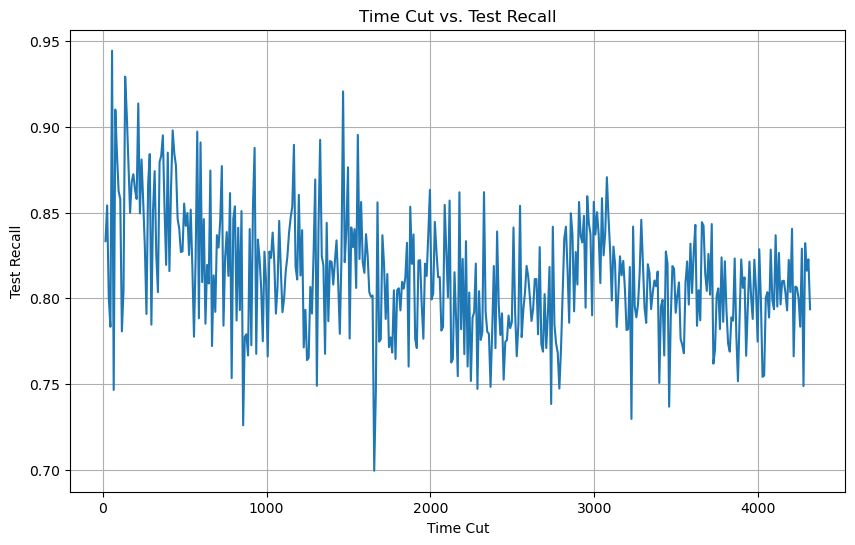

In [13]:
    # Ensure the metrics are numeric
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df['metrics.time_cut'] = pd.to_numeric(df['metrics.time_cut'], errors='coerce')
df['metrics.test_recall'] = pd.to_numeric(df['metrics.test_recall'], errors='coerce')
    
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_recall', data=df)
plt.title('Time Cut vs. Test Recall')
plt.xlabel('Time Cut')
plt.ylabel('Test Recall')
plt.grid(True)
plt.show()

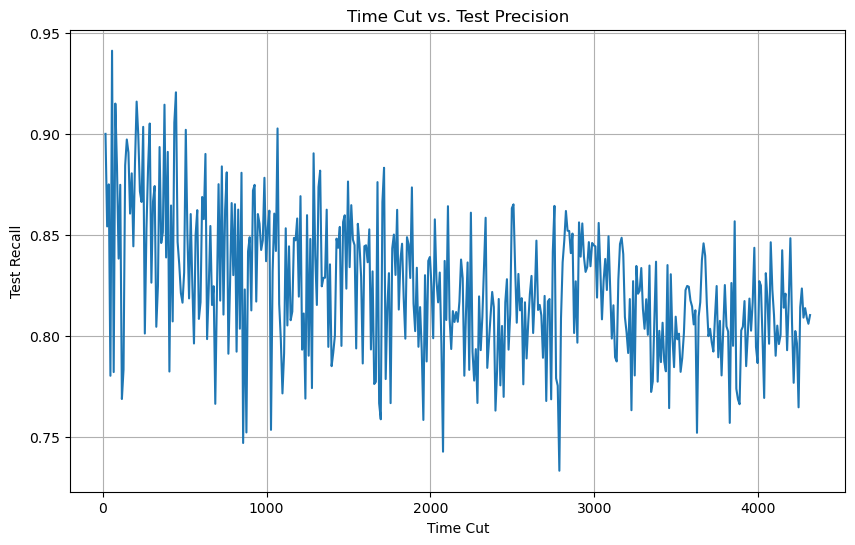

In [14]:
    # Ensure the metrics are numeric
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df['metrics.time_cut'] = pd.to_numeric(df['metrics.time_cut'], errors='coerce')
df['metrics.test_precision'] = pd.to_numeric(df['metrics.test_precision'], errors='coerce')
    
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_precision', data=df)
plt.title('Time Cut vs. Test Precision')
plt.xlabel('Time Cut')
plt.ylabel('Test Recall')
plt.grid(True)
plt.show()